<a href="https://colab.research.google.com/github/BunnyNoBugs/minor2021-iad3-spring/blob/main/sem08_recsys/sem08_recsys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Прикладные задачи анализа данных 2021

## Рекомендательные системы - 1

Ссылка на этот ноутбук в колабе

В этом задании будем практиковаться в реализации рекомендательных систем.

Воспользуемся небольшим датасетом с Kaggle: [Articles Sharing and Reading from CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop).

In [19]:
%pylab inline

import pandas as pd

from tqdm import tqdm_notebook, tqdm

Populating the interactive namespace from numpy and matplotlib


## Часть 0. Загрузка данных

Загрузим Deskdrop dataset, включающийся в себе логи за 1 год платформы, где пользователи читают статьи.

Данные включают в себя 2 файла:  
- **shared_articles.csv**
- **users_interactions.csv**

Как можно догадаться, в одном описания самих статей (нам понадобятся в контентных моделях), а в другом логи пользователей.

In [20]:
# загружаем и разархивируем данные
!pip3 -q install cython
!pip3 -q install git+https://github.com/coreylynch/pyFM
!pip3 -q install catboost
!wget -q -N "https://www.dropbox.com/s/z8syrl5trawxs0n/articles.zip?dl=0" -O articles.zip
!unzip -o -q articles.zip

#### shared_articles.csv

Так как в файле перечислены даже удалённые статьи, то мы их сразу удалим (на самом деле они могли бы быть нам полезны для подсчёта различных величин, хоть мы и не можем их рекомендовать).

In [21]:
articles_df = pd.read_csv('./articles/shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(2)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en


#### users_interactions.csv

В колонке eventType описаны действия, которые могли совершать пользователи над статьёй:  
- VIEW
- LIKE
- COMMENT CREATED
- FOLLOW
- BOOKMARK

In [22]:
interactions_df = pd.read_csv('./articles/users_interactions.csv')
interactions_df.head(10)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR
6,1465415950,VIEW,-8864073373672512525,3609194402293569455,1143207167886864524,NaN,NaN,NaN
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
8,1465413762,VIEW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
9,1465413771,VIEW,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN


In [23]:
interactions_df.personId = interactions_df.personId.astype(str)
interactions_df.contentId = interactions_df.contentId.astype(str)
articles_df.contentId = articles_df.contentId.astype(str)

### Предобработка данных

В логах встречаются различные действия пользователей. Однако мы хотим работать лишь с одной величиной, характеризующей всё взаимодействие пользователя со статьёй. Предлагается задать действиям следующие веса:

In [24]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

Посчитаем числовую величину "оценки" пользователем статьи с указанными выше весами.

In [25]:
interactions_df['eventStrength'] = interactions_df.eventType.apply(lambda x : event_type_strength[x])

In [26]:
interactions_df['eventStrength']

0        1.0
1        1.0
2        1.0
3        3.0
4        1.0
        ... 
72307    2.0
72308    1.0
72309    1.0
72310    1.0
72311    1.0
Name: eventStrength, Length: 72312, dtype: float64

Ремендательные системы подвержены проблеме холодного старта. Будем работать только с теми пользователями, которые взаимодействовали хотя бы с 5-ю материалами.

Оставим только таких пользователей.

In [27]:
users_interactions_count_df = (
    interactions_df
    .groupby(['personId', 'contentId'])
    .first()
    .reset_index()
    .groupby('personId').size())
print('# users:', len(users_interactions_count_df))

users_with_enough_interactions_df = \
    users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions:',len(users_with_enough_interactions_df))

# users: 1895
# users with at least 5 interactions: 1140


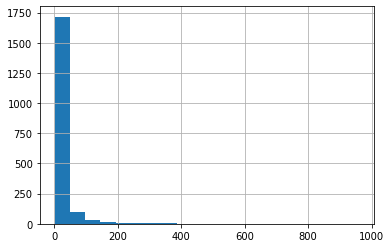

In [28]:
users_interactions_count_df.hist(bins=20)

Оставим только те взаимодействия, которые касаются только отфильтрованных пользователей.

In [29]:
interactions_from_selected_users_df = interactions_df.loc[np.in1d(interactions_df.personId,
            users_with_enough_interactions_df)]

In [30]:
print('# interactions before:', interactions_df.shape)
print('# interactions after:', interactions_from_selected_users_df.shape)

# interactions before: (72312, 9)
# interactions after: (69868, 9)


В данной постановке каждый пользователей мог взаимодействовать с каждой статьёй более 1 раза (как минимум совершая различные действия). Предлагается "схлопнуть" все действия в одно взаимодействие с весом, равным сумме весов. 

Однако полученное число будет в том числе тем больше, чем больше действий произвёл человек. Чтобы уменьшить разброс предлагается взять логарифм от полученного числа (можно придумывать другие веса действиям и по-другому обрабатывать значения).

Также сохраним последнее значение времени взаимодействия для разделениея выборки на обучение и контроль.

In [31]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId']).eventStrength.sum()
    .apply(smooth_user_preference)
    .reset_index().set_index(['personId', 'contentId'])
)
interactions_full_df['last_timestamp'] = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId'])['timestamp'].last()
)
        
interactions_full_df = interactions_full_df.reset_index()
interactions_full_df.head(20)

,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.000000,1470395911
1,-1007001694607905623,-6623581327558800021,1.000000,1487240080
2,-1007001694607905623,-793729620925729327,1.000000,1472834892
3,-1007001694607905623,1469580151036142903,1.000000,1487240062
4,-1007001694607905623,7270966256391553686,1.584963,1485994324
5,-1007001694607905623,8729086959762650511,1.000000,1487240086
6,-1032019229384696495,-1006791494035379303,1.000000,1469129122
7,-1032019229384696495,-1039912738963181810,1.000000,1459376415
8,-1032019229384696495,-1081723567492738167,2.000000,1464054093
9,-1032019229384696495,-1111518890369033396,1.000000,1470109122


Разобьём выборку на обучение и контроль по времени.

In [32]:
from sklearn.model_selection import train_test_split

split_ts = 1475519530
interactions_train_df = interactions_full_df.loc[interactions_full_df.last_timestamp < split_ts].copy()
interactions_test_df = interactions_full_df.loc[interactions_full_df.last_timestamp >= split_ts].copy()

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

interactions_train_df

# interactions on Train set: 29329
# interactions on Test set: 9777


,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.0,1470395911
2,-1007001694607905623,-793729620925729327,1.0,1472834892
6,-1032019229384696495,-1006791494035379303,1.0,1469129122
7,-1032019229384696495,-1039912738963181810,1.0,1459376415
8,-1032019229384696495,-1081723567492738167,2.0,1464054093
...,...,...,...,...
39099,997469202936578234,9112765177685685246,2.0,1472479493
39100,998688566268269815,-1255189867397298842,1.0,1474567164
39101,998688566268269815,-401664538366009049,1.0,1474567449
39103,998688566268269815,6881796783400625893,1.0,1474567675


Также разбить данные можно не опираясь на временной фактор:
```python
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'], 
                                   test_size=0.25,
                                   random_state=42)

```
Как повлият такое разбиение на итоговый результат?

Для удобства подсчёта качества запишем данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказаниями в виде списков.

In [33]:
interactions = (
    interactions_train_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'contentId': 'true_train'})
    .set_index('personId')
)

interactions['true_test'] = (
    interactions_test_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
)

# заполнение пропусков пустыми списками
interactions.loc[pd.isnull(interactions.true_test), 'true_test'] = [
    list() for x in range(len(interactions.loc[pd.isnull(interactions.true_test), 'true_test']))]

interactions.head(1)

,true_train,true_test
personId,,
-1007001694607905623,"[-5065077552540450930, -793729620925729327]","[-6623581327558800021, 1469580151036142903, 72..."


## Часть 1: Baseline (модель по популярности)

Самой простой моделью рекомендаций (при этом достаточно сильной!) является модель, которая рекомендует наиболее популярные предметы. 

Реализуем её. Давайте считать, что рекомендуем мы по 10 материалов (такое ограничение на размер блока на сайте).

Посчитаем популярность каждой статьи, как сумму всех "оценок" взаимодействий с ней. Отсортируем материалы по их популярности.

In [34]:
popular_content = interactions_train_df.groupby('contentId').eventStrength.sum().reset_index().sort_values('eventStrength', ascending=False)['contentId'].values
popular_content

array(['-6783772548752091658', '-133139342397538859',
       '-8208801367848627943', ..., '6240076106289531207',
       '6541551984368289722', '7083316110921342538'], dtype=object)

In [35]:
interactions_train_df.groupby('contentId').eventStrength.sum().reset_index().sort_values('eventStrength', ascending=False)

,contentId,eventStrength
805,-6783772548752091658,231.177195
43,-133139342397538859,228.024567
1002,-8208801367848627943,189.937683
2211,8224860111193157980,186.044680
2111,7507067965574797372,179.094002
...,...,...
1982,6569723785655740276,1.000000
1368,2335028422423709400,1.000000
1942,6240076106289531207,1.000000
1980,6541551984368289722,1.000000


In [36]:
print(articles_df.loc[articles_df.contentId == popular_content[2]]['title'].values)

["Ray Kurzweil: The world isn't getting worse - our information is getting better"]


In [37]:
print(articles_df.loc[articles_df.contentId == popular_content[2363]]['title'].values)

['Sunset Blvd. (1950)']


Теперь необходимо сделать предсказания для каждого пользователя. Не забываем, что надо рекомендовать то, что пользователь ещё не читал (для этого нужно проверить, что материал не встречался в true_train).

In [38]:
top_k = 10

interactions['prediction_popular'] = (
    interactions.true_train
    .apply(
        lambda x:
        popular_content[~np.in1d(popular_content, x)][:top_k]
    )
)

interactions['prediction_popular'][0]

array(['-6783772548752091658', '-133139342397538859',
       '-8208801367848627943', '8224860111193157980',
       '7507067965574797372', '-2358756719610361882',
       '-6843047699859121724', '-1297580205670251233',
       '8657408509986329668', '3367026768872537336'], dtype=object)

Настало время оценить качество. Посчитаем precision@10 для каждого пользователя (доля угаданных рекомендаций). Усредним по всем пользователям. Везде далее будем считать эту же метрику.

In [39]:
def calc_precision(column):

    return (
        interactions
        .apply(
            lambda row:
            len(set(row['true_test']).intersection(
                set(row[column]))) /
            min(len(row['true_test']) + 0.001, 10.0),
            axis=1)).mean()

In [40]:
calc_precision('prediction_popular')

0.006454207722621084

## Часть 2. Коллаборативная фильтрация.

Перейдём к более сложному механизму рекомендаций, а именно коллаборативной фильтрации. Суть коллаборативной фильтрации в том, что учитывается схожесть пользователей и товаров между собой, а не факторы, которые их описывают. 

Для начала для удобства составим матрицу "оценок" пользователей. Нули будут обозначать отсутствие взаимодействия.

In [41]:
ratings = pd.pivot_table(
    interactions_train_df,
    values='eventStrength',
    index='personId',
    columns='contentId').fillna(0)

In [42]:
ratings.shape

(1112, 2366)

### Memory-based

Посчитаем схожести пользователей с помощью корреляции Пирсона. Для каждой пары учитываем только ненулевые значения.

Для скорости работы лучше переходить от pandas к numpy.

In [43]:
ratings_m = ratings.values

In [44]:
similarity_users = np.zeros((len(ratings_m), len(ratings_m)))

for i in tqdm_notebook(range(len(ratings_m)-1)):
    for j in range(i+1, len(ratings_m)):
        
        # nonzero elements of two users
        mask_uv = (ratings_m[i] != 0) & (ratings_m[j] != 0)
        
        # continue if no intersection
        if np.sum(mask_uv) == 0:
            continue
            
        # get nonzero elements
        ratings_v = ratings_m[i, mask_uv]
        ratings_u = ratings_m[j, mask_uv]
        
        # for nonzero std
        if len(np.unique(ratings_v)) < 2 or len(np.unique(ratings_u)) < 2:
            continue

        
        similarity_users[i,j] = np.corrcoef(ratings_u, ratings_v)[0, 1]
        similarity_users[j,i] = similarity_users[i,j]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


Теперь у нас есть матрицы схожести пользователей. Их можно использовать для рекомендаций.

Для каждого пользователя:

1. Найдём пользователей с похожестью больше $\alpha$ на нашего пользователя.
2. Посчитаем для каждой статьи долю пользователей (среди выделенных на первом шаге), которые взаимодействовали со статьёй.
3. Порекомендуем статьи с наибольшими долями со второго шага (среди тех, которые пользователь ещё не видел).

В нашем примере данных не очень много, поэтому возьмём $\alpha = 0$.

После того, как будут сделаны предсказания (новый столбец в interactions), посчитаем качество по той же метрике.

In [45]:
similarity_users.shape

(1112, 1112)

In [46]:
prediction_user_based = []

for i in tqdm_notebook(range(len(similarity_users))):
    users_sim = similarity_users[i] > 0
    if len(users_sim) == 0:
        prediction_user_based.append([])
    else:
        tmp_recommend = np.argsort(ratings_m[users_sim].sum(axis=0))[::-1]
        tmp_recommend = ratings.columns[tmp_recommend]
        recommend = np.array(tmp_recommend)[~np.in1d(tmp_recommend, interactions.iloc[i])][:10]
        prediction_user_based.append(list(recommend))

interactions['prediction_user_based'] = prediction_user_based

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [47]:
calc_precision('prediction_user_based')

0.003541692918885617

### Модель со скрытыми переменными

Реализуем подход с разложением матрицы оценок. Для этого сделаем сингулярное разложение (svd в scipy.linalg), на выходе вы получите три матрицы.

Заметим, что мы используем матрицу с нулями, будто отсутствующие взаимодействия негативные, что странно.

Если бы мы учили модель со скрытыми переменными с помощью стохастического градиентного спуска, то неизвестные взаимодействия могли бы не использовать.

In [48]:
from scipy.linalg import svd

In [49]:
U, sigma, V = svd(ratings)
print(ratings.shape, U.shape, sigma.shape, V.shape)

(1112, 2366) (1112, 1112) (1112,) (2366, 2366)


In [50]:
Sigma = np.zeros((1112, 2366))
Sigma[:1112, :1112] = np.diag(sigma)

new_ratings = U.dot(Sigma).dot(V)
print(sum(sum((new_ratings - ratings.values) ** 2)))

1.0049074409063946e-24


Значения у матрицы с сингулярными числами отсортированы по убыванию. Допустим мы хотим оставить только первые 100 компонент (и получить скрытые представления размерности 100). Для этого необходимо оставить 100 столбцов в матрице U, оставить из sigma только первые 100 значений (и сделать из них диагональную матрицу). Перемножим преобразованные матрицы ($\hat{U}, \hat{sigma}, \hat{V^T}$), чтобы получить восстановленную матрицу оценок.

In [51]:
K = 100
new_ratings = U[:, :K].dot(Sigma[:K]).dot(V)

Посчитаем качество аппроксимации матрицы по норме Фробениуса (среднеквадратичную ошибку между всеми элементами соответствующими элементами двух матриц). Сравним его с простым бейзлайном с константным значением, равным среднему значению исходной матрицы. У аппроксимации ошибка должна получиться ниже.

In [52]:
print(sum(sum((new_ratings - ratings.values) ** 2)))
print(sum(sum((ratings.values.mean() - ratings.values) ** 2)))

25843.424898912766
78622.13000466056


Теперь можно делать предсказания по матрице. Сделаем их (не забываем про то, что уже было просмотрено пользователем), оценим качество. Для этого необходимо для каждого пользователя найти предметы с наибольшими оценками в восстановленной матрице.

In [53]:
new_ratings = pd.DataFrame(new_ratings, index=ratings.index, columns=ratings.columns)
predictions = []

for personId in tqdm_notebook(interactions.index):
    prediction = (
        new_ratings
        .loc[personId]
        .sort_values(ascending=False)
        .index.values
    )
    
    predictions.append(
        list(prediction[~np.in1d(
            prediction,
            interactions.loc[personId, 'true_train'])])[:top_k])

interactions['prediction_svd'] = predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [54]:
calc_precision('prediction_svd')

0.012212989310270754

Как это будет зависеть от числа компонент?

In [55]:
K_prec = []

for K in [1, 10, 50, 100, 500, 1000]:
    new_ratings = U[:, :K].dot(Sigma[:K]).dot(V)
    
    new_ratings = pd.DataFrame(new_ratings, index=ratings.index, columns=ratings.columns)
    predictions = []

    for personId in tqdm_notebook(interactions.index):
        prediction = (
            new_ratings
            .loc[personId]
            .sort_values(ascending=False)
            .index.values
        )

        predictions.append(
            list(prediction[~np.in1d(
                prediction,
                interactions.loc[personId, 'true_train'])])[:top_k])

    interactions[f'prediction_svd_{K}'] = predictions
    K_prec.append(calc_precision(f'prediction_svd_{K}'))
    interactions.drop([f'prediction_svd_{K}'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


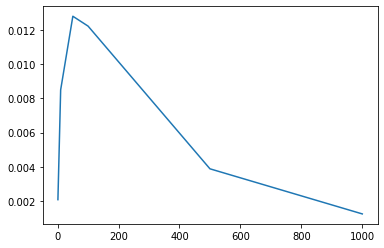

In [56]:
plt.plot([1, 10, 50, 100, 500, 1000], K_prec)

## Часть 3. Контентные  модели

В этой части реализуем альтернативный подход к рекомендательным системам — контентные модели.

Теперь мы будем оперировать не матрицей с оценками, а классической для машинного обучения матрицей объекты-признаки. Каждый объект будет характеризовать пару user-item и содержать признаки, описывающие как пользователя, так и товар. Кроме этого признаки могут описывать и саму пару целиком.

Матрица со всеми взаимодействиями уже получена нами на этапа разбиения выборки на 2 части. 

Будем обучать классификатор на взаимодействие, а для него нужны отрицательные примеры. Добавим случайные отсутствующие взаимодействия как отрицательные.

Заметим, что модель оценивает каждую пару потенциального взаимодействия, а значит, надо подготовить выборку из всех возможных пар из пользователей и статей.

In [57]:
test_personId = np.repeat(interactions.index, len(ratings.columns)) 
test_contentId = list(ratings.columns) * len(interactions)
test = pd.DataFrame(
    np.array([test_personId, test_contentId]).T,
    columns=['personId', 'contentId'])

interactions_train_df = pd.concat((
    interactions_train_df,
    test.loc[
        np.random.permutation(test.index)[
            :4*len(interactions_train_df)]]), ignore_index=True)
interactions_train_df.eventStrength.fillna(0, inplace=True)

Придумаем и добавим признаков о пользователях и статьях. Сначала добавим информацию о статьях в данные о взаимодействиях.

In [58]:
interactions_train_df = interactions_train_df.merge(articles_df, how='left', on='contentId')
interactions_test_df = interactions_test_df.merge(articles_df, how='left', on='contentId')

In [59]:
# first feature index
features_start = len(interactions_train_df.columns)

После обучения модели нам придётся делать предсказания на тестовой выборке для всех возможных пар статья-пользователь. Подготовим такую матрицу, чтобы параллельно посчитать признаки для неё.

In [60]:
test_personId = np.repeat(interactions.index, len(articles_df)) 
test_contentId = list(articles_df.contentId) * len(interactions)
test = pd.DataFrame(
    np.array([test_personId, test_contentId]).T,
    columns=['personId', 'contentId'])
test = test.merge(articles_df, how='left', on='contentId')

test.head()

,personId,contentId,timestamp,eventType,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,-1007001694607905623,-4110354420726924665,1459193988,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,-1007001694607905623,-7292285110016212249,1459194146,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
2,-1007001694607905623,-6151852268067518688,1459194474,CONTENT SHARED,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
3,-1007001694607905623,2448026894306402386,1459194497,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
4,-1007001694607905623,-2826566343807132236,1459194522,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


Добавим признаки-индикаторы возможных значений contentType.

In [61]:
interactions_train_df['is_HTML'] = interactions_train_df.contentType == 'HTML'
interactions_train_df['is_RICH'] = interactions_train_df.contentType == 'RICH'
interactions_train_df['is_VIDEO'] = interactions_train_df.contentType == 'VIDEO'

test['is_HTML'] = test.contentType == 'HTML'
test['is_RICH'] = test.contentType == 'RICH'
test['is_VIDEO'] = test.contentType == 'VIDEO'

Добавим признаки "длина названия" и "длина текста" + некоторые проверки на ключевые слова.

In [62]:
interactions_train_df['title_length'] = interactions_train_df.title.fillna('').apply(len)
interactions_train_df['text_length'] = interactions_train_df.text.fillna('').apply(len)

test['title_length'] = test.title.fillna('').apply(len)
test['text_length'] = test.text.fillna('').apply(len)

interactions_train_df['has_new'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'new' in x.lower())
interactions_train_df['has_why'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'why' in x.lower())
interactions_train_df['has_how'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'how' in x.lower())
interactions_train_df['has_ai'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'ai' in x.lower())

test['has_new'] = \
    test.title.fillna('').apply(lambda x: 'new' in x.lower())
test['has_why'] = \
    test.title.fillna('').apply(lambda x: 'why' in x.lower())
test['has_how'] = \
    test.title.fillna('').apply(lambda x: 'how' in x.lower())
test['has_ai'] = \
    test.title.fillna('').apply(lambda x: 'ai' in x.lower())

Добавим признаки-индикаторы языка.

In [63]:
interactions_train_df['is_lang_en'] = interactions_train_df.lang == 'en'
interactions_train_df['is_lang_pt'] = interactions_train_df.lang == 'pt'

test['is_lang_en'] = test.lang == 'en'
test['is_lang_pt'] = test.lang == 'pt'

Обучим на полученных признаках градиентный бустинг.

In [64]:
import catboost 

model = catboost.CatBoostClassifier()
model.fit(interactions_train_df[interactions_train_df.columns[features_start:]],
          np.array(interactions_train_df.eventStrength > 0, dtype=int))

Learning rate set to 0.086682
0:	learn: 0.6578548	total: 105ms	remaining: 1m 44s
1:	learn: 0.6290463	total: 143ms	remaining: 1m 11s
2:	learn: 0.6052198	total: 198ms	remaining: 1m 5s
3:	learn: 0.5860653	total: 232ms	remaining: 57.7s
4:	learn: 0.5700255	total: 280ms	remaining: 55.7s
5:	learn: 0.5570026	total: 327ms	remaining: 54.2s
6:	learn: 0.5461129	total: 369ms	remaining: 52.4s
7:	learn: 0.5372640	total: 413ms	remaining: 51.2s
8:	learn: 0.5301535	total: 447ms	remaining: 49.2s
9:	learn: 0.5243288	total: 491ms	remaining: 48.6s
10:	learn: 0.5193718	total: 535ms	remaining: 48.1s
11:	learn: 0.5152016	total: 574ms	remaining: 47.3s
12:	learn: 0.5119258	total: 607ms	remaining: 46s
13:	learn: 0.5089950	total: 654ms	remaining: 46.1s
14:	learn: 0.5067669	total: 688ms	remaining: 45.2s
15:	learn: 0.5046828	total: 733ms	remaining: 45.1s
16:	learn: 0.5031119	total: 769ms	remaining: 44.5s
17:	learn: 0.5015955	total: 808ms	remaining: 44.1s
18:	learn: 0.5002020	total: 862ms	remaining: 44.5s
19:	learn: 

Сделаем предсказания на тестовой выборке, сформируем из них рекомендации. 

In [66]:
predictions = model.predict_proba(test[interactions_train_df.columns[features_start:]])[:, 1]
test['predictions'] = predictions

test = test.sort_values('predictions', ascending=False)
predictions = test.groupby('personId')['contentId'].aggregate(list)
tmp_predictions = []

for personId in tqdm_notebook(interactions.index):
    prediction = np.array(predictions.loc[personId])
    
    tmp_predictions.append(
        list(prediction[~np.in1d(
            prediction,
            interactions.loc[personId, 'true_train'])])[:top_k])
    
interactions['prediction_content'] = tmp_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Оценим их качество.

In [67]:
calc_precision('prediction_content')

0.007644612680964311

## Часть 4. Факторизационная машина

Вспомним, что факторизационная машина учитывает попарные взаимодействия признаков, что приводит сразу и к использованию контента (сами признаки), и к обучению скрытых представлений (индикаторы пользователей и статей).

Попробуем факторизационные машины из библиотеки pyFM (так как можно работать прямо из питона). https://github.com/coreylynch/pyFM

In [68]:
from pyfm import pylibfm
from sklearn.feature_extraction import DictVectorizer

Перейдём к обобщению матричных разложений — факторизационным машинам, которые могут работать с контентной информацией. Вспомним, какие данные у нас изначально были:

В факторизационную машину можно загрузить "айдишники" пользователей и статей (то есть сделать аналог коллаборативной фильтрации) и одновременно различные признаки.

Удобно обрабатывать категориальные переменные (id и другие) можно с помощью DictVectorizer. Например, процесс может выглядить вот так:
```python
train = [
    {"user": "1", "item": "5", "age": 19},
    {"user": "2", "item": "43", "age": 33},
    {"user": "3", "item": "20", "age": 55},
    {"user": "4", "item": "10", "age": 20},
]
v = DictVectorizer()
X = v.fit_transform(train)
y = np.repeat(1.0, X.shape[0])
fm = pylibfm.FM()
fm.fit(X,y)
fm.predict(v.transform({"user": "1", "item": "10", "age": 24}))
```

Сгенерируем таблицу с признаками в таком виде, где будут id пользователя, статьи и автора статьи и несколько признаков, которые вы сможете придумать.

In [69]:
train_data = []

for i in tqdm_notebook(range(len(interactions_train_df))):
    features = {}
    features['personId'] = str(interactions_train_df.iloc[i].personId)
    features['contentId'] = str(interactions_train_df.iloc[i].contentId)
    
    try:
        article = articles_df.loc[features['contentId']]
        features['authorId'] = str(article.authorPersonId)
        features['authorCountry'] = str(article.authorCountry)
        features['lang'] = str(article.lang)
    except:
        features['authorId'] = 'unknown'
        features['authorCountry'] = 'unknown'
        features['lang'] = 'unknown'

    train_data.append(features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


Повторим эту процедуру для тестовой выборки. Заметим, что модель оценивает каждую пару потенциального взаимодействия, а значит, надо подготовить выборку из всех возможных пар из пользователей и статей.

In [70]:
from copy import deepcopy

test_data = []

for i in tqdm_notebook(range(len(interactions))):
    features = {}
    features['personId'] = str(interactions.index[i])  
    for j in range(len(ratings.columns)):
        
        features['contentId'] = str(ratings.columns[j])
        
        try:
            article = articles_df.loc[features['contentId']]
            features['authorId'] = str(article.authorPersonId)
            features['authorCountry'] = str(article.authorCountry)
            features['lang'] = str(article.lang)
        except:
            features['authorId'] = 'unknown'
            features['authorCountry'] = 'unknown'
            features['lang'] = 'unknown'
        
        test_data.append(deepcopy(features))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


Векторизуем, получим разреженные матрицы.

Мы будем обучать регрессор на силу взаимодействия, а для него нужны отрицательные примеры. Добавим некоторое количество случайных примеров как негативные (матрица взаимодействий разреженная, поэтому шансы взять как негативное взаимодействие некоторое положительное мало).

In [71]:
dv = DictVectorizer()

train_features = dv.fit_transform(
    train_data + list(np.random.permutation(test_data)[:100000]))
test_features = dv.transform(test_data)

In [72]:
train_features

<246645x3481 sparse matrix of type '<class 'numpy.float64'>'
	with 1233225 stored elements in Compressed Sparse Row format>

In [73]:
y_train = list(interactions_train_df.eventStrength.values) + list(np.zeros(100000))

Укажем размером скрытого представления 10, сделаем 10 итераций.

In [74]:
fm = pylibfm.FM(num_factors=10, num_iter=30, task='regression')

fm.fit(train_features, y_train)

Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.11759
-- Epoch 2
Training MSE: 0.11125
-- Epoch 3
Training MSE: 0.11132
-- Epoch 4
Training MSE: 0.11181
-- Epoch 5
Training MSE: 0.11153
-- Epoch 6
Training MSE: 0.11093
-- Epoch 7
Training MSE: 0.11025
-- Epoch 8
Training MSE: 0.10954
-- Epoch 9
Training MSE: 0.10904
-- Epoch 10
Training MSE: 0.10863
-- Epoch 11
Training MSE: 0.10816
-- Epoch 12
Training MSE: 0.10713
-- Epoch 13
Training MSE: 0.10617
-- Epoch 14
Training MSE: 0.10493
-- Epoch 15
Training MSE: 0.10382
-- Epoch 16
Training MSE: 0.10302
-- Epoch 17
Training MSE: 0.10172
-- Epoch 18
Training MSE: 0.10046
-- Epoch 19
Training MSE: 0.09969
-- Epoch 20
Training MSE: 0.09876
-- Epoch 21
Training MSE: 0.09788
-- Epoch 22
Training MSE: 0.09663
-- Epoch 23
Training MSE: 0.09590
-- Epoch 24
Training MSE: 0.09524
-- Epoch 25
Training MSE: 0.09513
-- Epoch 26
Training MSE: 0.09469
-- Epoch 27
Training MSE: 0.09408
-- Epoch 28
Tra

Предскажем и оценим качество.

In [75]:
####### Здесь ваш код ##########
test_features = dv.transform(test_data)

y_predict = fm.predict(test_features)

new_ratings = y_predict.reshape((1112, 2366))
################################

In [76]:
predictions = []

for i, person in enumerate(interactions.index):
    user_prediction = ratings.columns[np.argsort(new_ratings[i])[::-1]]
    predictions.append(
        user_prediction[~np.in1d(user_prediction,
                                 interactions.loc[person, 'true_train'])][:top_k])
    
interactions['fm_prediction'] = predictions

In [77]:
calc_precision('fm_prediction')

0.006760729486693511